In [1]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import numpy as np
from statistics import mean
from statistics import stdev

## Load Data

In [2]:
path = 'scale_data/scaledata'
list_dir = os.listdir(path)
list_dir

['Dennis+Schwartz', 'James+Berardinelli', 'Scott+Renshaw', 'Steve+Rhodes']

In [3]:
reviews_list = list() ## A list of all reviews
for direc in list_dir:
    file = os.path.join(path, direc, "subj." + direc) 
    reviews_file = open(file)
    reviews_file_contents = reviews_file.read()
    reviews_list.extend(reviews_file_contents.splitlines())
    reviews_file.close()

In [4]:
ratings_list = list() ## A list of all ratings (Note this ratings are strings and we will convert those to float later)
for direc in list_dir:
    file = os.path.join(path, direc, "rating." + direc) 
    ratings_file = open(file)
    ratings_file_contents = ratings_file.read()
    ratings_list.extend(ratings_file_contents.splitlines())
    ratings_file.close()

In [5]:
## Convert ratings to float    
ratings_list = np.array(ratings_list)
ratings_list = ratings_list.astype('float64') 
ratings_list = list(ratings_list)

## Train-Test Split

In [6]:
full_reviews_list_train, full_reviews_list_test, full_ratings_list_train, ratings_list_test = train_test_split(reviews_list, ratings_list, test_size=0.30, random_state=42)

## Train-Validation Split

In [7]:
reviews_list_train, reviews_list_val, ratings_list_train, ratings_list_val = train_test_split(full_reviews_list_train, full_ratings_list_train, test_size=0.25, random_state=1)

## Transform Data

In [8]:
def tfidf_train(newsgroups_train, n_features):
    """
    Train a TFIDF vectorizer and compute the TFIDF representation of the train data.

    Args:
        newsgroups_train (ndarray): corpus of all documents from all categories in train set
        n_features (int): vocabulary size
    Returns:
        vectorizer_train (object): trained tfidf vectorizer
        feature_names_train (list): list of features extracted from the trained tfidf vectorizer
        X_train (ndarray): tfidf word-document matrix of train data

    """
    # Extract Tfidf weights
    stop_words_list = nltk.corpus.stopwords.words('english')
    vectorizer_train = TfidfVectorizer(max_features=n_features,
                                    min_df=5, max_df=0.70,
                                    token_pattern = '[a-zA-Z]+',
                                    stop_words = stop_words_list)
    vectors_train = vectorizer_train.fit_transform(newsgroups_train)
    feature_names_train = vectorizer_train.get_feature_names() #features list
    dense_train = vectors_train.todense()

    denselist_train = np.array(dense_train).transpose() # tfidf matrix
    X_train = denselist_train.copy() # train data (tfidf)

    return vectorizer_train, feature_names_train, X_train

In [9]:
def tfidf_transform(vectorizer_train, newsgroups_test):
    """
    Apply TFIDF transformation to test data.

    Args:
        vectorizer_train (object): trained tfidf vectorizer
        newsgroups_test (ndarray): corpus of all documents from all categories in test set
    Returns:
        X_test (ndarray): tfidf word-document matrix of test data
    """

    vectors_test = vectorizer_train.transform(newsgroups_test)
    dense_test = vectors_test.todense()
    denselist_test = np.array(dense_test).transpose()
    X_test = denselist_test.copy()

    return X_test

In [10]:
def shuffle_data(X,y):
    """
    Shuffle data X, labels y

    Args/Returns:
        X (ndarray): data matrix, shape (vocabulary, documents)
        y (ndarray): labels, shape (documents,)
    """
    data = np.row_stack((X, y))
    np.random.shuffle(data.T)
    X = data[:-1,:]
    y = data[-1,:]

    return X, y

In [11]:
# Compute the TFIDF representation of the train set
vectorizer_train, feature_names_train, X_train = tfidf_train(reviews_list_train, n_features = 5000)

In [12]:
train_ratings = np.array(ratings_list_train)
X_train, train_ratings = shuffle_data(X_train, train_ratings)

In [13]:
# Apply TFIDF transformation to validation set
X_val = tfidf_transform(vectorizer_train, reviews_list_val)
val_ratings = np.array(ratings_list_val)
X_val, val_ratings = shuffle_data(X_val, val_ratings)

In [14]:
# Compute the TFIDF representation of the full train set
vectorizer_train_full, feature_names_train_full, X_train_full = tfidf_train(full_reviews_list_train, n_features = 5000)
full_train_ratings = np.array(full_ratings_list_train)
X_train_full, full_train_ratings = shuffle_data(X_train_full, full_train_ratings)

In [15]:
# Apply TFIDF transformation to test data set
X_test = tfidf_transform(vectorizer_train_full, full_reviews_list_test)
test_ratings = np.array(ratings_list_test)
X_test, test_ratings = shuffle_data(X_test, test_ratings)

In [16]:
## Convert rating 1-d rating arrays to 2-D to use in SSNMF
train_ratings = train_ratings[np.newaxis, :]
val_ratings = val_ratings[np.newaxis, :]
full_train_ratings = full_train_ratings[np.newaxis, :]
test_ratings = test_ratings[np.newaxis, :]

In [17]:
X_train.shape

(5000, 2628)

In [18]:
train_ratings.shape

(1, 2628)

### SSNMF

In [19]:
import ssnmf
from ssnmf.evaluation  import Evaluation
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import max_error

In [20]:
class Methods:

    def __init__(self, X_train, X_val, X_test, y_train, y_val, y_test, X_train_full,\
                    y_train_full):
        """
        Class for all methods.
        Parameters:
            X_train (ndarray): tfidf train data matrix, shape (vocabulary size, number of train documents)
            X_val (ndarray): tfidf validation data matrix, shape (vocabulary size, number of val documents)
            X_test (ndarray): tfidf test data matrix, shape (vocabulary size, number of test documents)
            y_train (ndarray): outcome of all documents in train set
            y_val (ndarray):  outcome of all documents in val set
            y_test (ndarray):  outcome of all documents in test set
            X_train_full (ndarray): tfidf full train data matrix, shape (vocabulary size, number of full train documents)
            y_train_full (ndarray):  labels of all documents in full train set
        """
        self.X_train = X_train
        self.X_val = X_val
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.y_val = y_val
        self.X_train_full = X_train_full
        self.y_train_full = y_train_full
        
    def SSNMF(self, modelNum, ssnmf_tol, lamb, ka, itas, print_results=0):
        """
        Run (S)SNMF on the TFIDF representation of documents.
        Args:
            modelNum (int): SSNMF model number
            ssnmf_tol (float): tolerance for termanating SSNMF model
            lamb (float): regularization parameter of SSNMF
            ka (int): input rank for SSNMF
            itas (int): maximum number of multiplicative update iterations
            hyp_search (boolean): 0: run hyperparameter search algorithm, 1:otherwise
            print_results (boolean): 1: print classification report, heatmaps, and keywords, 0:otherwise
        Retruns:
            test_evals(list): [float(total reconstruction error (model objective function) on test data),
                                    float(data reconstruction error on test data),
                                    float(label reconstruction error on test data),
                                    float(classification accuracy on test data)]
            eval_module.model.A (ndarray): learnt word dictionary matrix for data reconstruction, shape (words, topics)
            eval_module.model.B (ndarray): learnt dictionary matrix for classification, shape (classes, topics)
            ssnmf_predicted (ndarray): predicted labels for data points in test set
            ssnmf_iter (int): actual number of iterations of SSNMF model
            S (ndarray): document representation matrix for train set, shape (topics, train + test documents)
            S_test (ndarray): document representation matrix for test set, shape (topics, test documents)
        """

        print("\nRunning SSNMF for Model {}.".format(modelNum))
        self.ssnmf_tol = ssnmf_tol
        self.modelNum = modelNum

       
        self.opt_ka = ka
        self.opt_lamb = lamb
        self.opt_itas = itas
        
        eval_module = Evaluation(train_features = self.X_train_full,
                                 train_labels = self.y_train_full,
                                 test_features = self.X_test, test_labels = self.y_test, tol = self.ssnmf_tol,
                                 modelNum = self.modelNum, k = self.opt_ka, lam=self.opt_lamb, numiters = self.opt_itas)

        train_evals, test_evals = eval_module.eval()
        ssnmf_iter = len(train_evals[0])


        ssnmf_predicted = eval_module.model.B@eval_module.S_test

        S = eval_module.model.S
        S_test = eval_module.S_test

        return test_evals[:-1], eval_module.model.A, eval_module.model.B, ssnmf_predicted, ssnmf_iter, S, S_test


### Run SSNMF for one set of lamda and tolerence values

In [ ]:
iterations = 11
rank = 13
ssnmf_lam = 1e-4
ssnmf_tol = 1e+1
# Construct an evaluation module
evalualtion_module = Methods(X_train = X_train, X_val = X_val, X_test = X_val,\
                             y_train = train_ratings, y_val = val_ratings,\
                             y_test = val_ratings, X_train_full = X_train,\
                             y_train_full = train_ratings)

for j in range(iterations):
    print("Iteration {}.".format(j))
    test_evals, A, B, ssnmf_predicted, ssnmf_iter, S, S_test = evalualtion_module.SSNMF(modelNum = 4,
                                                                        ssnmf_tol = ssnmf_tol,lamb = ssnmf_lam, ka = rank, itas= 50)
        

Iteration 0.

Running SSNMF for Model 4.
Iteration 1.

Running SSNMF for Model 4.
Iteration 2.

Running SSNMF for Model 4.
Iteration 3.

Running SSNMF for Model 4.
Iteration 4.

Running SSNMF for Model 4.
Iteration 5.

Running SSNMF for Model 4.
Iteration 6.

Running SSNMF for Model 4.
Iteration 7.

Running SSNMF for Model 4.
Iteration 8.

Running SSNMF for Model 4.
Iteration 9.

Running SSNMF for Model 4.


-1.196128454868814


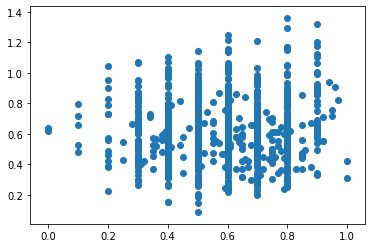

In [22]:
## Calculate R**2
## y = np.squeeze(val_ratings)
## y_hat = np.squeeze(ssnmf_predicted)  
## 1-(sum((y-y_hat)**2)/sum((y-np.mean(y))**2))
r2_val = r2_score(np.squeeze(val_ratings), np.squeeze(ssnmf_predicted))
print(r2_val)

import matplotlib.pyplot as plt
plt.scatter(np.squeeze(val_ratings), np.squeeze(ssnmf_predicted))
plt.show()

In [23]:
## Calculate MSE
MSE_val = mean_squared_error(np.squeeze(val_ratings), np.squeeze(ssnmf_predicted))
print(MSE_val)

0.0710948015648122


In [24]:
## Calculate MAE
MAE_val = mean_absolute_error(np.squeeze(val_ratings), np.squeeze(ssnmf_predicted))
print(MAE_val)

0.21260213003330242


In [25]:
## Calculate maximum error
max_error = max_error(np.squeeze(val_ratings), np.squeeze(ssnmf_predicted))
print(max_error)

0.8464537094392659


### Run SSNMF for various tolerance and regularizer values

In [26]:
# ------------ PARAMETERS ------------
rank = 13 # (int) input rank for NMF and (S)SNMF models
iterations = 3 # (odd int) number of iterations to run for analysis

In [27]:
""" Run SSNMF for various tolerance and regularizer values."""

tol_list = [1e-4,1e-3,1e-2]
lam_list = [1e+1,1e+2,1e+3]
mean_dict = {"Model3": [], "Model4": [], "Model5": [], "Model6": []}
std_dict = {"Model3": [], "Model4": [], "Model5": [], "Model6": []}

for lam_idx in range (len(lam_list)):
    ssnmf_lam = lam_list[lam_idx]
    print("Testing lambda equal to {}.".format(ssnmf_lam))
    for tol_idx in range (len(tol_list)):
        ssnmf_tol = tol_list[tol_idx]
        print("Testing tolerance equal to {}.".format(ssnmf_tol))
        acc_dict = {"Model3": [], "Model4": [], "Model5": [], "Model6": []}
        # Construct an evaluation module
        evalualtion_module = Methods(X_train = X_train, X_val = X_val, X_test = X_val,\
                            y_train = train_ratings, y_val = val_ratings,\
                            y_test = val_ratings, X_train_full = X_train,\
                            y_train_full = train_ratings)

        for j in range(iterations):
            print("Iteration {}.".format(j))
            for i in range(3,7):
                # Run SSNMF
                test_evals, A, B, ssnmf_predicted, ssnmf_iter, S, S_test = evalualtion_module.SSNMF(modelNum = i,
                                                                        ssnmf_tol = ssnmf_tol,lamb = ssnmf_lam, ka = rank, itas= 50)
                ## Calculate R**2
                acc_dict["Model" + str(i)].append(r2_score(np.squeeze(val_ratings), np.squeeze(ssnmf_predicted)))
                
                ## Calculate MSE
                ## acc_dict["Model" + str(i)].append(mean_squared_error(np.squeeze(val_ratings), np.squeeze(ssnmf_predicted)))
                
                ## Calculate MAE
                ## acc_dict["Model" + str(i)].append(mean_absolute_error(np.squeeze(val_ratings), np.squeeze(ssnmf_predicted)))
    
        for i in range(3,7):
            acc = acc_dict["Model" + str(i)]
            mean_dict["Model" + str(i)].append(mean(acc))
            std_dict["Model" + str(i)].append(stdev(acc))
            print("Model {} average accuracy (with tol = {} and lam = {}): {:.4f} ± {:.4f}.".format(i,ssnmf_tol,ssnmf_lam,mean(acc),stdev(acc)))

for i in range(3,7):
    idx_final = 0
    for lam_idx in range(len(lam_list)):
        ssnmf_lam = lam_list[lam_idx]
        for tol_idx in range (len(tol_list)):
            ssnmf_tol = tol_list[tol_idx]
            m_final = mean_dict["Model" + str(i)][idx_final]
            s_final = std_dict["Model" + str(i)][idx_final]
            print("Model {} average accuracy (with tol = {} and lam = {}): {:.4f} ± {:.4f}.".format(i,ssnmf_tol,ssnmf_lam,m_final,s_final))
            idx_final += 1
    print()


Testing lambda equal to 10.0.
Testing tolerance equal to 0.0001.
Iteration 0.

Running SSNMF for Model 3.

Running SSNMF for Model 4.

Running SSNMF for Model 5.

Running SSNMF for Model 6.
Iteration 1.

Running SSNMF for Model 3.

Running SSNMF for Model 4.

Running SSNMF for Model 5.

Running SSNMF for Model 6.
Iteration 2.

Running SSNMF for Model 3.

Running SSNMF for Model 4.

Running SSNMF for Model 5.

Running SSNMF for Model 6.
Model 3 average accuracy (with tol = 0.0001 and lam = 10.0): -0.3820 ± 0.2659.
Model 4 average accuracy (with tol = 0.0001 and lam = 10.0): -0.3799 ± 0.2399.
Model 5 average accuracy (with tol = 0.0001 and lam = 10.0): 0.1705 ± 0.0470.
Model 6 average accuracy (with tol = 0.0001 and lam = 10.0): 0.1203 ± 0.1310.
Testing tolerance equal to 0.001.
Iteration 0.

Running SSNMF for Model 3.

Running SSNMF for Model 4.

Running SSNMF for Model 5.

Running SSNMF for Model 6.
Iteration 1.

Running SSNMF for Model 3.

Running SSNMF for Model 4.

Running SSNMF for